# 프로젝트: ResNet Ablation Study
## 1. 데이터셋 준비하기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [5]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


## 2. Input Normalization

In [6]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    image = tf.image.resize(image, (224,224))
    return tf.cast(image, tf.float32) / 255., label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
ds_info.features["label"].num_classes

2

In [9]:
ds_info.features["label"].names

['cat', 'dog']

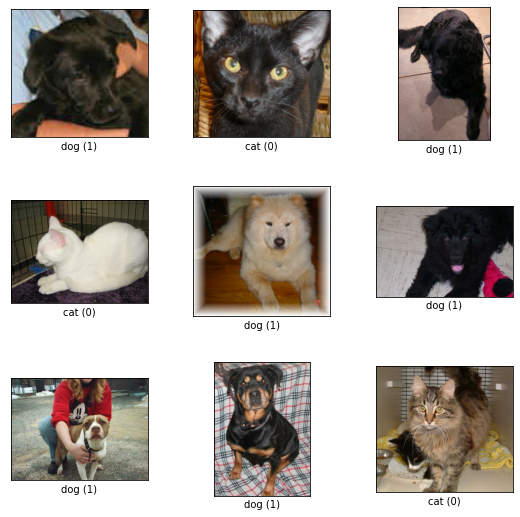

In [10]:
fig = tfds.show_examples(ds_train, ds_info)

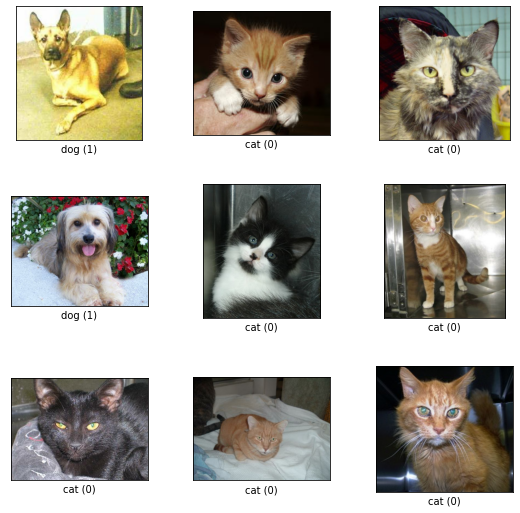

In [11]:
fig = tfds.show_examples(ds_test, ds_info)

## 3. ResNet 기본 블록 구성하기
이제 실전으로 돌아와서 **ResNet-34**와 **ResNet-50** 네트워크를 직접 만든다고 생각해 봅시다. 우선 ResNet-34와 ResNet-50에서 사용되는 블록의 공통점을 찾고 차이점을 찾아봅시다.

- [Deep Residual Learning for Image Recognition(paper)](https://arxiv.org/pdf/1512.03385.pdf)
- [빛과 같은 카이밍허님의 깃헙](https://github.com/KaimingHe/deep-residual-networks)

<img src="img/imagenet.png">

In [12]:
def conv_block(
    input_layer, 
    channel, 
    kernel_size, 
    strides=1, 
    activation='relu'):
    
    x = keras.layers.Conv2D(
        filters=channel,
        kernel_size=kernel_size,
        kernel_initializer='he_normal',
        kernel_regularizer=keras.regularizers.l2(1e-4),
        padding='same',
        strides=strides
        )(input_layer)
    
    x = keras.layers.BatchNormalization()(x)
    
    if activation:
        x = keras.layers.Activation(activation)(x)
    
    return x

In [13]:
def build_resnet_block(input_layer, 
                       num_cnn=3, 
                       channel=64, 
                       block_num=0, 
                       is_50=True):
    
    x = input_layer
    
    # ResNet-50
    if is_50:
        for i in range(num_cnn):
            if i == 0:
                shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    
    # ResNet-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    

    return x

In [14]:
def build_resnet(input_shape=(32,32,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=10, 
                 is_50=True, 
                 activation='softmax',
                 name='ResNet_50'):
    
    assert len(num_cnn_list) == len(channel_list) # 모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 Residual block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_resnet_block(x, 
                               num_cnn=num_cnn, 
                               channel=channel, 
                               block_num=block_num, 
                               is_50=is_50)
        
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation, 
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

<img src="img/Resnet.png" width="80%" height="80%">

## 4. ResNet-34, ResNet-50 Complete Model

### ResNet-34

In [15]:
resnet_34 = build_resnet(input_shape=(32,32,3), is_50=False, name='ResNet_34')
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
__________________________________________________________________________________________

### ResNet-50

In [16]:
resnet_50 = build_resnet(input_shape=(32,32,3), is_50=True)
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 16, 16, 64)   256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16, 16, 64)   0           batch_normalization_36[0][0]     
__________________________________________________________________________________________

## 5. 일반 네트워크(plain network) 만들기

### 블록 코드 수정하기

In [17]:
# resnet block에서 shortcut을 제외한 plain block
def build_plain_block(input_layer, 
                      num_cnn=3, 
                      channel=64, 
                      block_num=0, 
                      is_50=True):
    
    x = input_layer
    
    # plain-50
    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
            else:
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
    
    # plain-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3))
            else:
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3))

    return x

### 전체 함수 코드 수정하기

In [18]:
def build_plainnet(input_shape=(32,32,3), 
                   num_cnn_list=[3,4,6,3],
                   channel_list=[64,128,256,512],
                   num_classes=10,
                   is_50=True, 
                   activation='softmax',
                   name='Plain_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape)
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 plain block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_plain_block(x, 
                              num_cnn=num_cnn, 
                              channel=channel,
                              block_num=block_num,
                              is_50=is_50)
    
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation,
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

### Plain-34

In [19]:
plain_34 = build_plainnet(input_shape=(224,224,3), is_50=False, name='Plain_34')
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_89 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_82 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_90 (Batc (None, 56, 56, 64)        256

### Plain-50

In [20]:
plain_50 = build_plainnet(input_shape=(224,224,3), is_50=True)
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_122 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_115 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_normalization_123 (Bat (None, 56, 56, 64)        256

## 6. ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

### Ablation Study

In [21]:
BATCH_SIZE = 32
EPOCH = 5

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [22]:
resnet_34 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=False, 
                         activation='sigmoid', 
                         name='ResNet_34')

resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/5
581/581 [==============================] - 278s 435ms/step - loss: 2.2481 - accuracy: 0.5968 - val_loss: 1.4533 - val_accuracy: 0.5911
Epoch 2/5
581/581 [==============================] - 259s 445ms/step - loss: 1.2012 - accuracy: 0.6769 - val_loss: 2.7725 - val_accuracy: 0.5168
Epoch 3/5
581/581 [==============================] - 247s 426ms/step - loss: 0.7997 - accuracy: 0.7511 - val_loss: 1.1185 - val_accuracy: 0.5630
Epoch 4/5
581/581 [==============================] - 248s 426ms/step - loss: 0.6293 - accuracy: 0.7937 - val_loss: 0.6793 - val_accuracy: 0.7407
Epoch 5/5
581/581 [==============================] - 247s 426ms/step - loss: 0.5312 - accuracy: 0.8371 - val_loss: 0.8153 - val_accuracy: 0.5690


In [24]:
import pandas as pd
df_resnet_34 = pd.DataFrame({
    'train_loss': history_resnet_34.history['loss'],
    'val_acc': history_resnet_34.history['val_accuracy']
    })
df_resnet_34.to_csv('/aiffel/aiffel/GoingDeeper/resnet_ablation/data/history_resnet_34.csv', index=False)

In [25]:
resnet_50 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=True,
                         activation='sigmoid')

resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/5
581/581 [==============================] - 253s 366ms/step - loss: 5.5648 - accuracy: 0.5846 - val_loss: 3.4991 - val_accuracy: 0.6284
Epoch 2/5
581/581 [==============================] - 174s 299ms/step - loss: 3.0241 - accuracy: 0.6985 - val_loss: 2.3530 - val_accuracy: 0.5595
Epoch 3/5
581/581 [==============================] - 175s 301ms/step - loss: 1.8674 - accuracy: 0.7572 - val_loss: 1.4620 - val_accuracy: 0.7703
Epoch 4/5
581/581 [==============================] - 175s 301ms/step - loss: 1.3648 - accuracy: 0.7869 - val_loss: 1.3282 - val_accuracy: 0.6994
Epoch 5/5
581/581 [==============================] - 175s 301ms/step - loss: 1.0693 - accuracy: 0.8120 - val_loss: 1.4182 - val_accuracy: 0.6422


In [26]:
df_resnet_50 = pd.DataFrame({
    'train_loss': history_resnet_50.history['loss'],
    'val_acc': history_resnet_50.history['val_accuracy']
    })
df_resnet_50.to_csv('/aiffel/aiffel/GoingDeeper/resnet_ablation/data/history_resnet_50.csv', index=False)

In [27]:
plain_34 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=False, 
                          activation='sigmoid',
                          name='Plain_34')

plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/5
581/581 [==============================] - 246s 407ms/step - loss: 2.0269 - accuracy: 0.5925 - val_loss: 1.3871 - val_accuracy: 0.6342
Epoch 2/5
581/581 [==============================] - 236s 406ms/step - loss: 1.2537 - accuracy: 0.6571 - val_loss: 1.1989 - val_accuracy: 0.4965
Epoch 3/5
581/581 [==============================] - 236s 406ms/step - loss: 0.9968 - accuracy: 0.6784 - val_loss: 1.2138 - val_accuracy: 0.5409
Epoch 4/5
581/581 [==============================] - 236s 406ms/step - loss: 0.8379 - accuracy: 0.7226 - val_loss: 1.3602 - val_accuracy: 0.4933
Epoch 5/5
581/581 [==============================] - 236s 406ms/step - loss: 0.7638 - accuracy: 0.7414 - val_loss: 1.5129 - val_accuracy: 0.5920


In [28]:
df_plain_34 = pd.DataFrame({
    'train_loss': history_plain_34.history['loss'],
    'val_acc': history_plain_34.history['val_accuracy']
    })
df_plain_34.to_csv('/aiffel/aiffel/GoingDeeper/resnet_ablation/data/history_plain_34.csv', index=False)

In [29]:
plain_50 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=True,
                          activation='sigmoid')

plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/5
581/581 [==============================] - 395s 629ms/step - loss: 4.2504 - accuracy: 0.5092 - val_loss: 2.5649 - val_accuracy: 0.4929
Epoch 2/5
581/581 [==============================] - 382s 658ms/step - loss: 2.2412 - accuracy: 0.5204 - val_loss: 1.8384 - val_accuracy: 0.5144
Epoch 3/5
581/581 [==============================] - 371s 639ms/step - loss: 1.7498 - accuracy: 0.5337 - val_loss: 1.5622 - val_accuracy: 0.5052
Epoch 4/5
581/581 [==============================] - 364s 627ms/step - loss: 1.5030 - accuracy: 0.5505 - val_loss: 4.3599 - val_accuracy: 0.4994
Epoch 5/5
581/581 [==============================] - 364s 627ms/step - loss: 1.3208 - accuracy: 0.5498 - val_loss: 1.2625 - val_accuracy: 0.5762


In [30]:
df_plain_50 = pd.DataFrame({
    'train_loss': history_plain_50.history['loss'],
    'val_acc': history_plain_50.history['val_accuracy']
    })
df_plain_50.to_csv('/aiffel/aiffel/GoingDeeper/resnet_ablation/data/history_plain_50.csv', index=False)

### 학습 결과

In [31]:
history_resnet_34 = pd.read_csv('/aiffel/aiffel/GoingDeeper/resnet_ablation/data/history_resnet_34.csv')
history_resnet_50 = pd.read_csv('/aiffel/aiffel/GoingDeeper/resnet_ablation/data/history_resnet_50.csv')
history_plain_34 = pd.read_csv('/aiffel/aiffel/GoingDeeper/resnet_ablation/data/history_plain_34.csv')
history_plain_50 = pd.read_csv('/aiffel/aiffel/GoingDeeper/resnet_ablation/data/history_plain_50.csv')

### 시각화

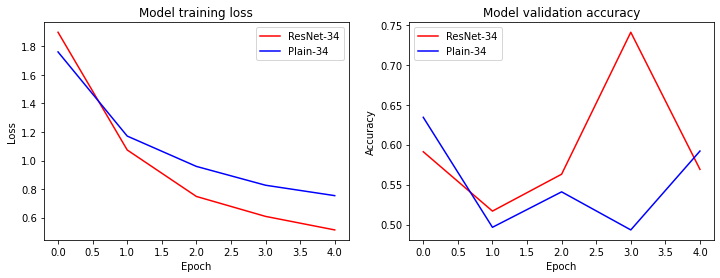

In [32]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_34['train_loss'], 'r')
plt.plot(history_plain_34['train_loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_34['val_acc'], 'r')
plt.plot(history_plain_34['val_acc'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper left')
plt.show()

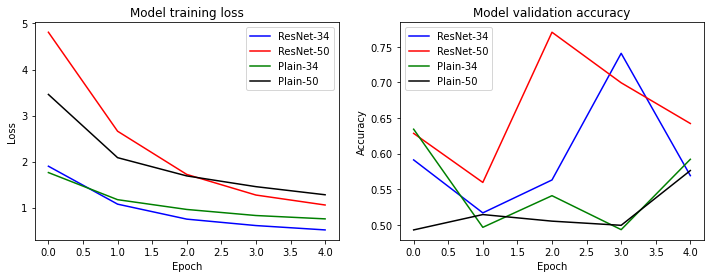

In [33]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_34['train_loss'], 'b')
plt.plot(history_resnet_50['train_loss'], 'r')
plt.plot(history_plain_34['train_loss'], 'g')
plt.plot(history_plain_50['train_loss'], 'k')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'ResNet-50', 'Plain-34', 'Plain-50'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_34['val_acc'], 'b')
plt.plot(history_resnet_50['val_acc'], 'r')
plt.plot(history_plain_34['val_acc'], 'g')
plt.plot(history_plain_50['val_acc'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'ResNet-50', 'Plain-34', 'Plain-50'], loc='upper left')
plt.show()